In [72]:
%config Completer.use_jedi = False

In [73]:
##Do the necessary imports
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import cv2
import torch


In [74]:
##key points are stored in a csv file.
##we will read that in
key_pts_frame = pd.read_csv('data/training_frames_keypoints.csv')
key_pts_frame.head(5)

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,126,127,128,129,130,131,132,133,134,135
0,Luis_Fonsi_21.jpg,45.0,98.0,47.0,106.0,49.0,110.0,53.0,119.0,56.0,...,83.0,119.0,90.0,117.0,83.0,119.0,81.0,122.0,77.0,122.0
1,Lincoln_Chafee_52.jpg,41.0,83.0,43.0,91.0,45.0,100.0,47.0,108.0,51.0,...,85.0,122.0,94.0,120.0,85.0,122.0,83.0,122.0,79.0,122.0
2,Valerie_Harper_30.jpg,56.0,69.0,56.0,77.0,56.0,86.0,56.0,94.0,58.0,...,79.0,105.0,86.0,108.0,77.0,105.0,75.0,105.0,73.0,105.0
3,Angelo_Reyes_22.jpg,61.0,80.0,58.0,95.0,58.0,108.0,58.0,120.0,58.0,...,98.0,136.0,107.0,139.0,95.0,139.0,91.0,139.0,85.0,136.0
4,Kristen_Breitweiser_11.jpg,58.0,94.0,58.0,104.0,60.0,113.0,62.0,121.0,67.0,...,92.0,117.0,103.0,118.0,92.0,120.0,88.0,122.0,84.0,122.0


In [75]:
image_name = key_pts_frame.iloc[0,0]
key_pts = key_pts_frame.iloc[0,1:].as_matrix().reshape(-1,2)
key_pts = key_pts.astype('float')
print(f"First 4 key points points :\n {key_pts[:4]}")
print(f"image name : {image_name}")

First 4 key points points :
 [[  45.   98.]
 [  47.  106.]
 [  49.  110.]
 [  53.  119.]]
image name : Luis_Fonsi_21.jpg


In [76]:
##Number of Training images
key_pts_frame.shape[0]

3462

In [77]:
def show_keypoints(image , key_pts) :
    
    plt.imshow(image)
    plt.scatter(x=key_pts[:,0], y=key_pts[:,1], s=20, marker = '*', c='m')

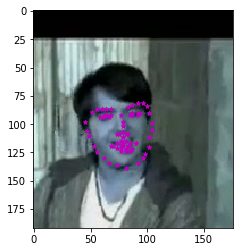

In [78]:
# Display a few different types of images by changing the index n

# select an image by index in our data frame
n=0
img = key_pts_frame.iloc[n,0]
img = os.path.join('data/training/',img)
img = cv2.imread(img)
key_pts = key_pts_frame.iloc[n,1:].as_matrix().reshape(-1,2)
key_pts = key_pts.astype('float')
show_keypoints(img,key_pts)

In [79]:
##Dataset class

class FacialKeypointsDataset(Dataset) :
    def __init__(self, csv_file, root_dir, transform=None) :
        self.key_pts_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self) :
        return len(self.key_pts_frame)
    
    def __getitem__(self, idx) :
        n = idx
        image = self.key_pts_frame.iloc[n,0]
        image_path = os.path.join(self.root_dir, image)
        image = cv2.imread(image_path)
        # if image has an alpha color channel, get rid of it
        if(image.shape[2] == 4):
            image = image[:,:,0:3]
        
        ##Key points for that particular image
        key_pts = self.key_pts_frame.iloc[n,1:].as_matrix()
        key_pts = key_pts.reshape(-1,2).astype('float')
        
        sample = {'image' : image , 'keypoints' : key_pts}
        
        if self.transform :
            sample = self.transform(sample)
        
        return sample
            

In [80]:
## Construct the Dataset
face_dataset = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv' , root_dir = 'data/training/')

##Print some data about dataset
print(f'length of dataset is {len(face_dataset)}')

length of dataset is 3462


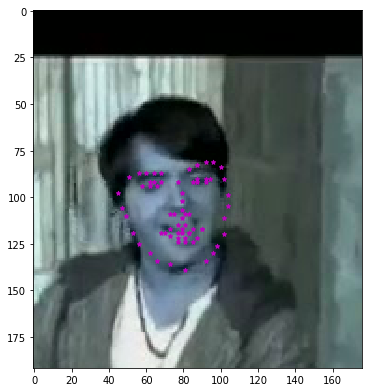

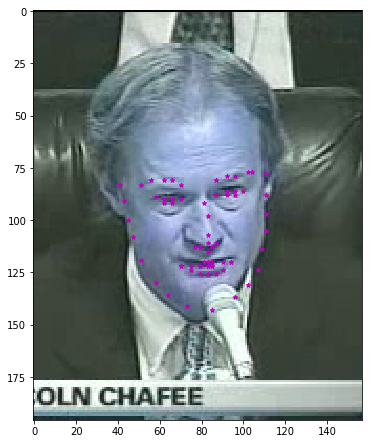

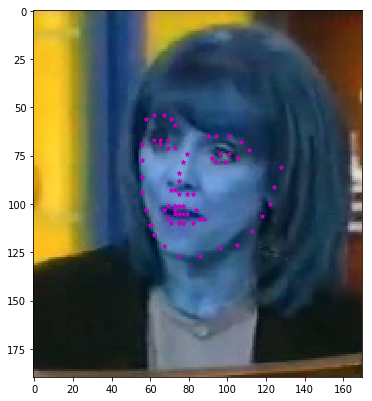

In [81]:
##Display a few images to test with help of 
##same old show_keypoints function
num_to_display = 3

for i in range(num_to_display) :
    fig = plt.figure(figsize=(20,10))
    img = face_dataset[i]['image']
    key_pts = face_dataset[i]['keypoints']
    ax = plt.subplot(1,num_to_display,i+1)
    show_keypoints(img , key_pts)
    

In [82]:
class Normalize :
    def __call__(self , sample) :
        ##scale the image betwwen 0 and 1 
        ##and covert to grayscale
        image = sample['image']
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = image/255.0
        
        ##scale keypoints to be centered around 0 with a range of [-1, 1]
        ## mean = 100, sqrt = 50, so, pts should be (pts - 100)/50
        key_pts = sample['keypoints']
        key_pts = (key_pts-100)/50.0
        
        return {'image' : image , 'keypoints' : key_pts} 


class Rescale :
    def __init__(self, output_size) :
        self.output_size = output_size
        
    def __call__(self, sample) :
        image = sample['image']
        w,h = image.shape[1], image.shape[0]
        
        key_pts = sample['keypoints']
        
        new_h , new_w = int(self.output_size), int(self.output_size)
        image = cv2.resize(image, (new_w, new_h))
        
        ##scale the keypoints too
        key_pts = key_pts * [new_w/w, new_h/h]
        
        return {'image' : image , 'keypoints' : key_pts}
    

class ToTensor :
    def __call__(self, sample) :
        image = sample['image']
        key_pts = sample['keypoints']
        if len(image.shape) != 3 :
            image = np.expand_dims(image , 2)
        
        image = image.transpose(2,0,1)
        image = torch.tensor(image)
        key_pts = torch.tensor(key_pts)
        
        return {'image' : image , 'keypoints' : key_pts}
        
        
        
        

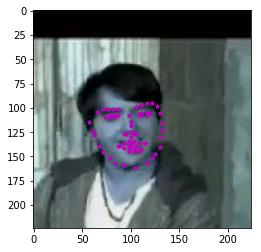

In [83]:
##Test the Rescale
rescale = Rescale(224)
sample = face_dataset[0]
#print(sample)
result = rescale(sample)
show_keypoints(result['image'],result['keypoints'])

In [84]:
##Create the transformed DataSet :

data_transform = transforms.Compose([Rescale(224) ,
                                    Normalize() ,
                                    ToTensor()])

transformed_dataset = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv', 
                                            root_dir='data/training/' ,
                                            transform=data_transform)

In [85]:
##Print info about dataset
len(transformed_dataset)

3462

In [86]:
for i in range(5):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])
4 torch.Size([1, 224, 224]) torch.Size([68, 2])


In [87]:
##Create a dataloader to 
##Load the data into bathces
from torch.utils.data import DataLoader
batch_size = 10
train_loader = DataLoader(transformed_dataset , batch_size , shuffle = True)

test_dataset = FacialKeypointsDataset('data/test_frames_keypoints.csv' , 'data/test/' , transform=data_transform)
test_loader = DataLoader(test_dataset , batch_size , shuffle=True)

In [105]:
## import our model architecture from python file

from model import Net

In [89]:
net = Net()
print(net)

Net(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(1, 68, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(68, 136, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(136, 272, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(272, 544, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(544, 1088, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(1088, 2176, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=2176, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=136, bias=True)
)


In [90]:
##Apply the model on a test sample
def sample_output() :
    for sample in test_loader :
        images = sample['image'].type(torch.FloatTensor)
        gt = sample['keypoints']
        
        key_pts = net(images).detach()
        key_pts = key_pts.view(key_pts.shape[0] , 68 , -1)
        #print(output)
        return images,key_pts,gt        

In [91]:
images, key_pts, gt = sample_output()

In [92]:
gt.shape

torch.Size([10, 68, 2])

In [93]:
##Visualize the predicted keypoints
##We will define a new function, 
##show_all_keypoints that displays a grayscale image, 
##its predicted keypoints and its ground truth keypoints (if provided).
def show_all_keypoints(image , key_pts , gt) :
    
    
    plt.figure()
    
    plt.imshow(image , cmap = 'gray')
    plt.scatter(key_pts[:,0] , key_pts[:,1] , s=20 , c='m' , marker = '.')
    if gt is not None :
        plt.scatter(gt[:,0] , gt[:,1] , s=20 , c='g' , marker = '.')
    

torch.Size([10, 68, 2])
torch.Size([68, 2])
torch.Size([68, 2])
torch.Size([68, 2])
torch.Size([68, 2])
torch.Size([68, 2])
torch.Size([68, 2])
torch.Size([68, 2])
torch.Size([68, 2])
torch.Size([68, 2])
torch.Size([68, 2])


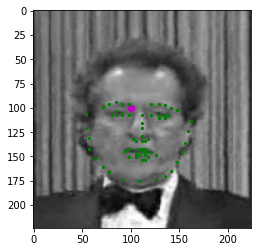

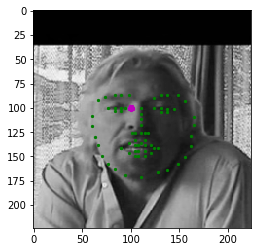

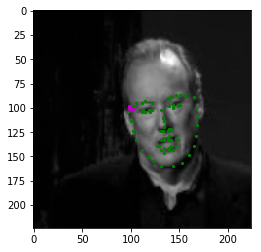

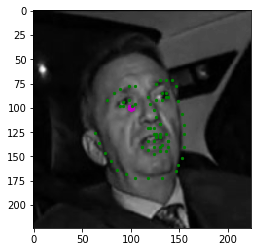

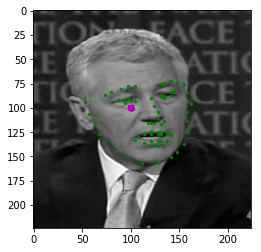

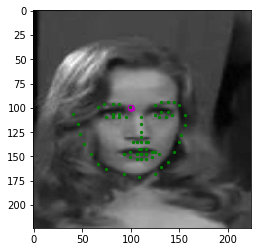

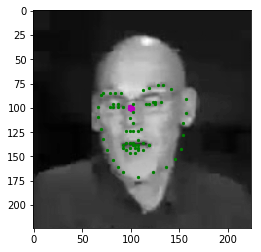

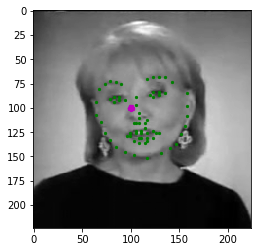

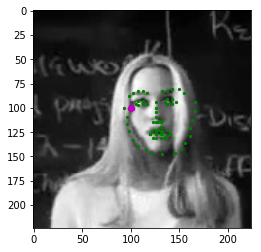

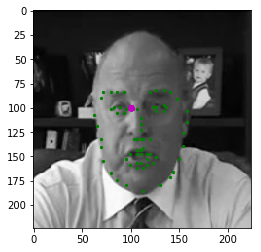

In [94]:
def visualize_output(images , outputs , gts) :

    print(gts.shape)
    for i in range(images.shape[0]) :
        image = images[i]
        image = image.numpy()
        image = image.transpose(1,2,0)
        image = np.squeeze(image)
        
        ##undo the normalization of predicted key points
        key_pts = outputs[i]
        key_pts = key_pts.numpy()
        key_pts = (key_pts*50) + 100
        
        ##undo the normalization of actual keypoints
        
        gt = gts[i]
        print(gt.shape)
        gt = (gt*50) + 100
            
        show_all_keypoints(image , key_pts , gt)
        
        
visualize_output(images , key_pts,gt)

In [109]:
##Define loss function and optimizer
##Then define the training loop
import torch.nn as nn
from torch import optim
net = Net()
loss_fn = nn.MSELoss()
optimizer = optim.Adam(net.parameters() , 0.001)

In [110]:
def trainin_loop(epochs , train_loader , loss_fn , optimizer , net ) :
    device = 'cuda'
    net.to(device)
    dtype = torch.cuda.FloatTensor
    for epoch in range(epochs) :
        train_loss = 0
        for samples in train_loader :
            images = samples['image']
            gts = samples['keypoints']
            #print(f"gts shape before : {gts.shape}")
            images = images.to(device).type(dtype)
            gts = gts.to(device).type(dtype)
            gts = gts.view(gts.shape[0],-1)
            #print(f"gts shape : {gts.shape}")
            key_pts = net(images)
            #print(f"key points shape : {key_pts.shape}")
            optimizer.zero_grad()
            
            loss = loss_fn(key_pts , gts)
            train_loss+=loss
            loss.backward()
            optimizer.step()
        
        print(f"epoch : {epoch+1} ; training loss : {train_loss}")
            

In [111]:
epochs = 10
trainin_loop(epochs , train_loader , loss_fn , optimizer , net)

epoch : 1 ; training loss : 79.10236358642578
epoch : 2 ; training loss : 21.803857803344727
epoch : 3 ; training loss : 21.427370071411133
epoch : 4 ; training loss : 21.283681869506836
epoch : 5 ; training loss : 21.440298080444336
epoch : 6 ; training loss : 21.25702476501465
epoch : 7 ; training loss : 20.901378631591797
epoch : 8 ; training loss : 19.90707015991211
epoch : 9 ; training loss : 14.158638954162598
epoch : 10 ; training loss : 9.812986373901367


In [112]:
##Test the model on test set
net.to('cpu')
images,key_pts,gt = sample_output()

torch.Size([10, 68, 2])
torch.Size([68, 2])
torch.Size([68, 2])
torch.Size([68, 2])
torch.Size([68, 2])
torch.Size([68, 2])
torch.Size([68, 2])
torch.Size([68, 2])
torch.Size([68, 2])
torch.Size([68, 2])
torch.Size([68, 2])


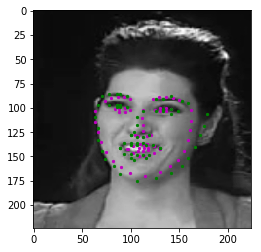

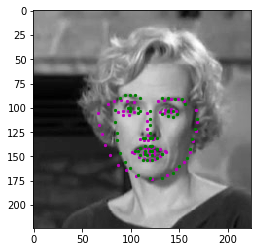

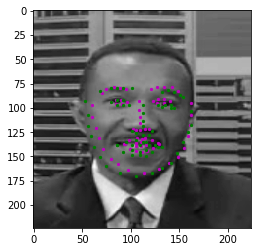

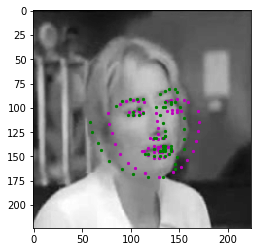

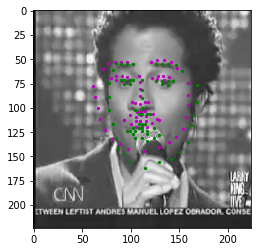

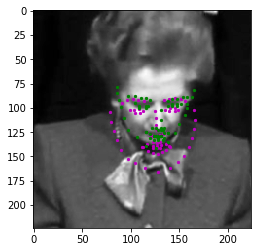

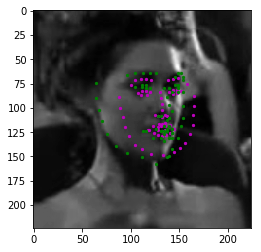

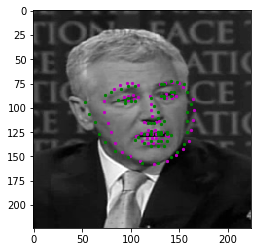

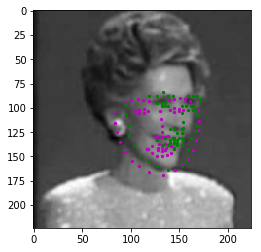

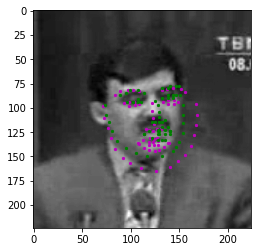

In [113]:
visualize_output(images , key_pts , gt)

In [114]:
##Now that we have found a decent model,
##we will save it to a file
model_dir = 'saved_models/'
model_name = 'final_model.pt'
torch.save(net.state_dict() , model_dir+model_name)